<a href="https://colab.research.google.com/github/Benqui/facial-recognition-on-keras/blob/main/Programa_reconocimiento_emociones_keras_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pillow
!pip install brewer2mpl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [3]:
# import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            document.body.removeChild(video);
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Get OpenCV format image
    img = js_to_image(data) 
    # Grayscale img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)
    # Draw face bounding box on image
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Save image
    cv2.imwrite(filename, img)

    return filename

In [8]:
def get_highest_value_position(array):
    # Get the index of the maximum value in the array
    max_index = np.argmax(array)
    
    # Convert the index to the corresponding position
    position = np.unravel_index(max_index, array.shape)
    
    return position

In [9]:
import time
import cv2
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
# def extrac_emotions(time_loop=300):
#   start_time = time.time()
#   end_time = start_time + time_loop  #son segundos

#   emotion = {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Surprise': 4, 'Neutral': 5}

#   emotion_arr = []

#   while time.time() < end_time:
#     try:
#       filename = take_photo('photo.jpg')
#       print('Saved to {}'.format(filename))
      
#       # Show the image which was just taken.
#       display(Image(filename))
#     except Exception as err:
#       # Errors will be thrown if the user does not have a webcam or if they do not
#       # grant the page permission to access it.
#       print(str(err))
  
#     face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

#     # Load the image
#     image = cv2.imread('/content/photo.jpg')

#     # Convert the image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Detect faces in the grayscale image
#     faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

#     # Iterate over the detected faces
#     for (x, y, w, h) in faces:
#         # Choose the face that corresponds to your face
#         # Adjust the conditions based on the position and size of the face in the image

#         # Example conditions: choose the first face with width and height greater than a threshold
#         if w > 100 and h > 100:
#             # Define the region of interest (ROI) around the face
#             roi = image[y:y+h, x:x+w]

#             # Display the cropped face image
#             cv2_imshow(roi)

#             # Save the cropped face image
#             cv2.imwrite('/content/cropped_face.jpg', roi)

#             break
#     img_path = '/content/cropped_face.jpg'
#     # Load the image using Keras
#     # img = image.load_img(img_path, target_size=(48, 48))
#     img = image.load_img(img_path, target_size=(48, 48))

#     # Display the image
#     img.show()
#     X = image.img_to_array(img)
#     X = np.expand_dims(X, axis=0)

#     model = tf.keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/mi_modelo_cuarentav3.h5')
#     model.summary()

#     X = preprocess_input(X)
#     preds = model.predict(X)

#     preds.shape

#     preds
#     print(preds.dtype)

#     if isinstance(preds, np.ndarray):
#         print("Variable is an array")
#     else:
#         print("Variable is not an array")

#     alfa=get_highest_value_position(preds)

#     print(type(alfa))
#     print(type(emotion))
#     print(alfa[-1])
#     check = alfa[-1]
    

#     for key, value in emotion.items():
#         if value == check:
#             print("The key associated with the value is:", key)
#             emotion_arr.append(key)
#             break

#     print(emotion_arr)
    
    
#     time.sleep(60)

In [11]:
def load_preds():
  img_path = '/content/cropped_face.jpg'
  # Load the image using PIL
  img = Image.open(img_path).resize((48, 48))
  # Display the image
  display(img)
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  model = tf.keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/mi_modelo_cuarentav3.h5')
  model.summary()
  X = preprocess_input(X)
  preds = model.predict(X)
  return preds
  

In [12]:
from PIL import Image
import time
import cv2
import numpy as np
from IPython.display import display
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab.patches import cv2_imshow

def extract_emotions(time_loop):
    start_time = time.time()
    end_time = start_time + time_loop  # in seconds

    emotion = {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Surprise': 4, 'Neutral': 5}

    emotion_arr = []

    while time.time() < end_time:
        try:
            filename = take_photo('photo.jpg')
            print('Saved to {}'.format(filename))

            # Show the image which was just taken.
            display(Image(filename))
        except Exception as err:
            # Errors will be thrown if the user does not have a webcam or if they do not
            # grant the page permission to access it.
            print(str(err))

        face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

        # Load the image
        image = cv2.imread('/content/photo.jpg')

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        # Iterate over the detected faces
        for (x, y, w, h) in faces:
            # Choose the face that corresponds to your face
            # Adjust the conditions based on the position and size of the face in the image

            # Example conditions: choose the first face with width and height greater than a threshold
            if w > 100 and h > 100:
                # Define the region of interest (ROI) around the face
                roi = image[y:y+h, x:x+w]

                # Display the cropped face image
                cv2_imshow(roi)

                # Save the cropped face image
                cv2.imwrite('/content/cropped_face.jpg', roi)

                break
        
        # img_path = '/content/cropped_face.jpg'
        # # Load the image using PIL
        # img = Image.open(img_path).resize((48, 48))

        # # Display the image
        # display(img)

        # X = image.img_to_array(img)
        # X = np.expand_dims(X, axis=0)

        # ==========================
        # img_path = resize_img()

        # model = tf.keras.models.load_model('/content/drive/MyDrive/Escuela/ia/reconocer-jetas/modelos_propios/mi_modelo_cuarentav3.h5')
        # model.summary()

        # X = preprocess_input(X)
        # # preds = model.predict(X)
        preds = load_preds()

        
        if isinstance(preds, np.ndarray):
            print("Variable is an array")
        else:
            print("Variable is not an array")

        alfa = get_highest_value_position(preds)
        print(type(alfa))
        # print(type(emotion))

        check = alfa[-1]

        for key, value in emotion.items():
            if value == check:
                print("The key associated with the value is:", key)
                emotion_arr.append(key)
                break

        print(emotion_arr)

        time.sleep(10)
    return emotion_arr



<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


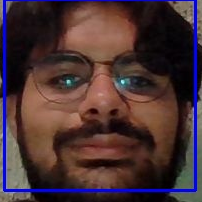

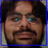

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


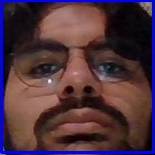

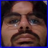

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


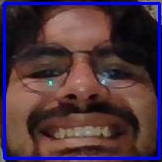

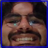

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


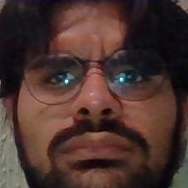

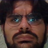

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


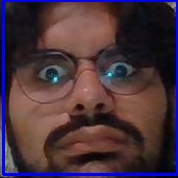

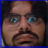

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

1/1 [==============================] - 1s 1s/step
Variable is an array
<class 'tuple'>
The key associated with the value is: Sad
['Neutral', 'Sad', 'Sad', 'Sad', 'Sad']


<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


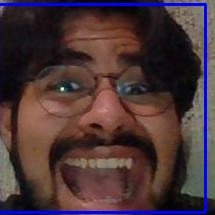

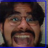

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

1/1 [==============================] - 1s 1s/step
Variable is an array
<class 'tuple'>
The key associated with the value is: Sad
['Neutral', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad']


In [13]:
arr_emotions= extract_emotions(time_loop=100)

In [16]:
print(arr_emotions)

['Neutral' 'Sad' 'Sad' 'Sad' 'Sad' 'Sad']


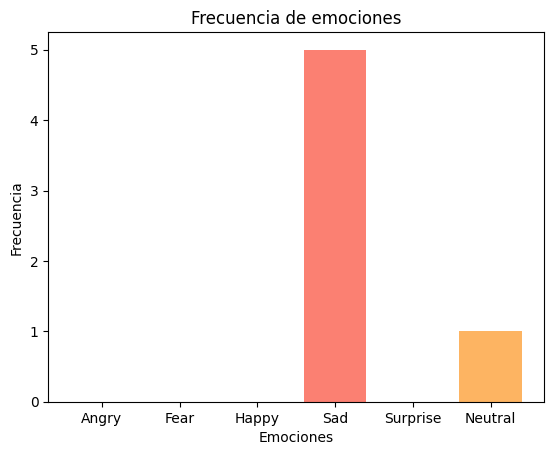

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import brewer2mpl

emotion = {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Surprise': 4, 'Neutral': 5}

arr_emotions = np.array(arr_emotions)

emotion_counts = {k: np.count_nonzero(arr_emotions == k) for k in emotion}

colors = brewer2mpl.get_map('Set3', 'qualitative', len(emotion)).mpl_colors

fig, ax = plt.subplots()
ax.bar(emotion_counts.keys(), emotion_counts.values(), color=colors)

ax.set_xlabel('Emociones')
ax.set_ylabel('Frecuencia')
ax.set_title('Frecuencia de emociones')

plt.show()
